### Goal
data description through some basic summary statistics: 
- [] vocabulary size 
- []  number of tweets available, 
- []  average sentiment, 
- [x]  concentration of tweets over time, 
- [x]  tweet length, 
- []  tweet views
    
    comment: plots before cleaning or after cleaning or both ?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.snowball import SnowballStemmer
import regex as re
import texthero as hero
from texthero import preprocessing as hp
from wordcloud import WordCloud
from nltk.corpus import stopwords
# nltk.download('stopwords')

%load_ext autoreload
%autoreload 2


In [3]:
df = pd.read_parquet('../data/tweet_data.parquet')

df['text_length'] = df['text'].apply(lambda text: len(text.split()))
df['day'] = pd.to_datetime(df['created_at'].apply(lambda date : date[0:10]))

print("There are", df.shape[0],"Elon tweets in the dataset")
df.head()


There are 24085 Elon tweets in the dataset


,id,created_at,text,hashtags,mentions,cashtags,is_reply,retweet_count,reply_count,like_count,quote_count,impression_count,text_length,day
0,1648218700875550721,2023-04-18T06:55:35.000Z,@Teslaconomics Intense work schedule,[],[Teslaconomics],[],True,1616,1810,35844,108,2067249,4,2023-04-18
1,1648218093393420288,2023-04-18T06:53:10.000Z,@0xgaut 🔥🔥,[],[0xgaut],[],True,704,454,19838,26,1046453,2,2023-04-18
2,1648212090660716544,2023-04-18T06:29:19.000Z,@dogeofficialceo 🤣,[],[dogeofficialceo],[],True,393,358,6986,24,632781,2,2023-04-18
3,1648199231688134657,2023-04-18T05:38:13.000Z,@Not_the_Bee Sigh,[],[Not_the_Bee],[],True,1205,961,25641,59,1377332,2,2023-04-18
4,1648198647283163136,2023-04-18T05:35:54.000Z,@IncompetentHum3 !,[],[IncompetentHum3],[],True,2959,1420,28808,109,1529066,2,2023-04-18


### Cumulative number of tweets over time

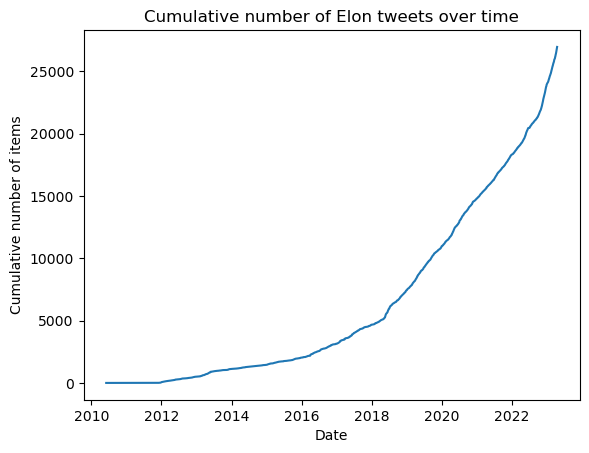

In [13]:
counts = df.groupby('day')['id'].nunique() + 1
cumulative_counts = counts.cumsum()
# plt.yscale('log')
plt.plot(cumulative_counts.index, cumulative_counts)
plt.title('Cumulative number of Elon tweets over time')
plt.xlabel('Date')
plt.ylabel('Cumulative number of items')
plt.show()

### Distribution of tweet length (# of words)

In [14]:
# DF of only replies
replies = df[df['is_reply'] == True]

# DF of only tweets
tweets = df[df['is_reply'] == False]

print("There are", tweets.shape[0],"tweets in the dataset,   constituting", round(tweets.shape[0]/df.shape[0]*100,2),"% of the dataset")
print("There are", replies.shape[0],"replies in the dataset, constituting", round(replies.shape[0]/df.shape[0]*100,2),"% of the dataset")

There are 3673 tweets in the dataset,   constituting 15.25 % of the dataset
There are 20412 replies in the dataset, constituting 84.75 % of the dataset


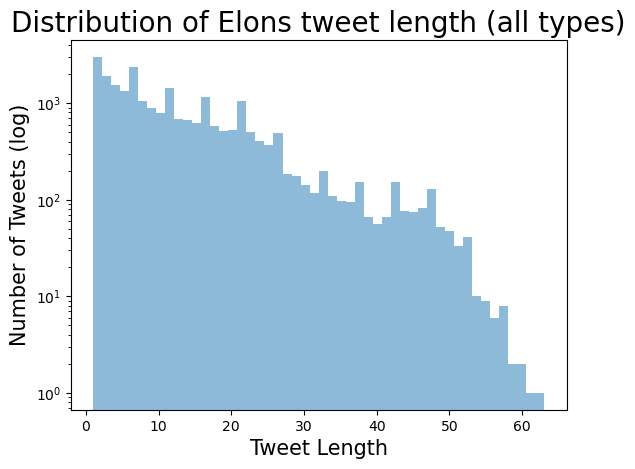

The median length of a tweet is 9.0
The mean length of a tweet is 12.72223375544945


In [15]:
def plot_histogram(data, title, xlabel, ylabel, xlegend, bins = 50, log = False):
    if log:
        plt.yscale('log')

    axes = plt.gca()
    axes.xaxis.label.set_size(15)
    axes.yaxis.label.set_size(15)

    plt.hist(data, bins = bins, alpha = 0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title,fontsize = 20)
    # plt.legend()
    plt.show()

plot_histogram(df['text_length'], 
               title = 'Distribution of Elons tweet length (all types)',
               xlabel = 'Tweet Length', 
               ylabel = 'Number of Tweets (log)', 
               xlegend = 'Tweet Length', 
               bins=50, log = True)
    
print("The median length of a tweet is", df['text_length'].median())
print("The mean length of a tweet is", df['text_length'].mean())

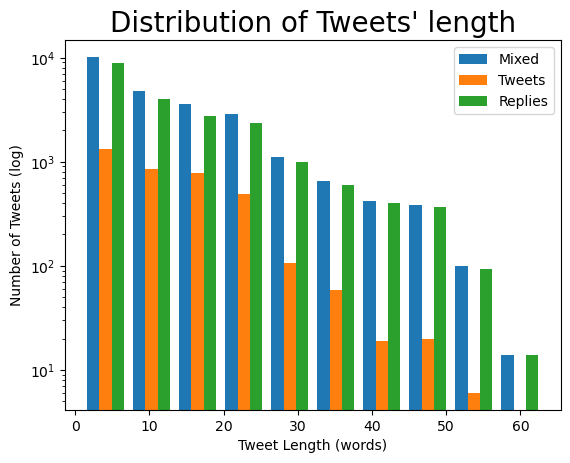

In [16]:
# Note: it might not be useful to have the mixed (tweet + replies) here, or the above plot is not useful. 

plt.yscale('log')
plt.hist([df['text_length'], tweets['text_length'], replies['text_length']], label=['Mixed','Tweets', 'Replies'])
plt.legend(loc='upper right')
plt.ylabel('Number of Tweets (log)')
plt.xlabel('Tweet Length (words)')
plt.title('Distribution of Tweets\' length', fontsize = 20)
plt.show()

### Tweet mean length over time

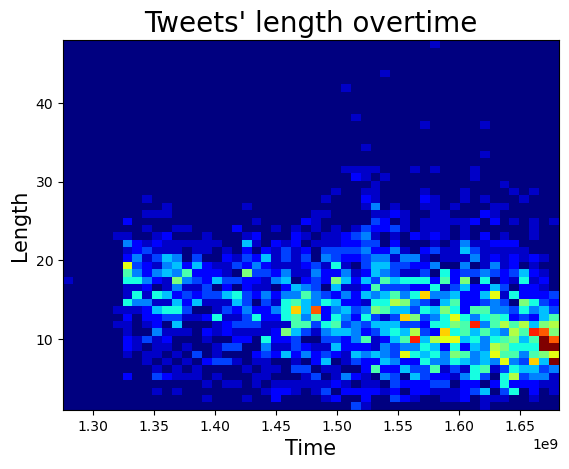

In [17]:
dailylen = df[['text_length','day']].groupby(by = 'day').mean().reset_index()

axes = plt.gca()
axes.xaxis.label.set_size(15)
axes.yaxis.label.set_size(15)
plt.ylabel('Length')
plt.xlabel('Time')

plt.title('Tweets\' length overtime', fontsize = 20)
# date_format = plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
# plt.xticks(rotation=45, ha='right')
plt.hist2d(pd.to_datetime(dailylen['day']).astype(int) // 10**9, dailylen['text_length'], (50, 50), cmap=plt.cm.jet)

plt.show()

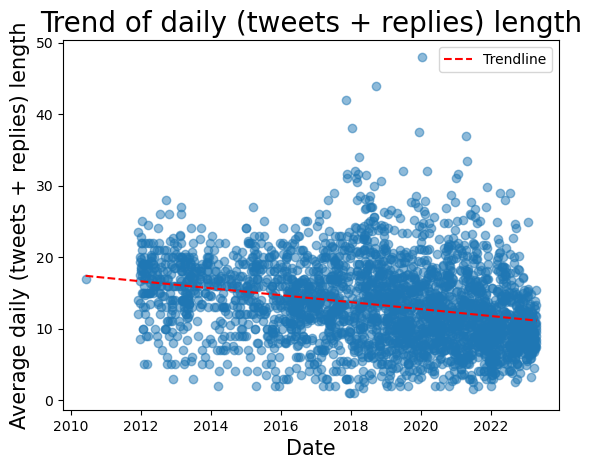

We see that length of elon musk's tweets are decreasing over time!
Does it hold if we look at tweets and replies separately?


In [18]:
def plot_trend(df, 
               title = 'Trend of daily (tweets + replies) length', 
               ylabel = 'Average daily (tweets + replies) length', 
               xlabel = 'Date'):    
    axes = plt.gca()
    axes.xaxis.label.set_size(15)
    axes.yaxis.label.set_size(15)
    plt.xlabel(xlabel= xlabel)
    plt.ylabel(ylabel= ylabel)
    plt.title(title ,fontsize = 20)
    plt.scatter(df['day'], df['text_length'], alpha = 0.5,)

    # Add a trendline
    z = np.polyfit(df['day'].astype(np.int64) // 10**9, df['text_length'], 1)
    p = np.poly1d(z)
    plt.plot(df['day'], p(df['day'].astype(np.int64) // 10**9),"r--", label='Trendline')

    plt.legend()
    plt.show()

plot_trend(dailylen)
print("We see that length of elon musk's tweets are decreasing over time!")
print("Does it hold if we look at tweets and replies separately?")

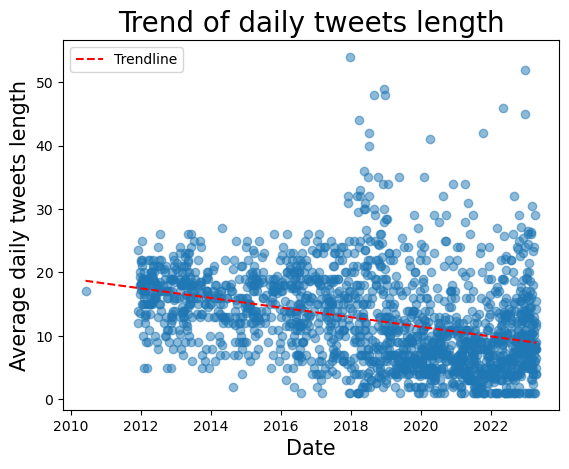

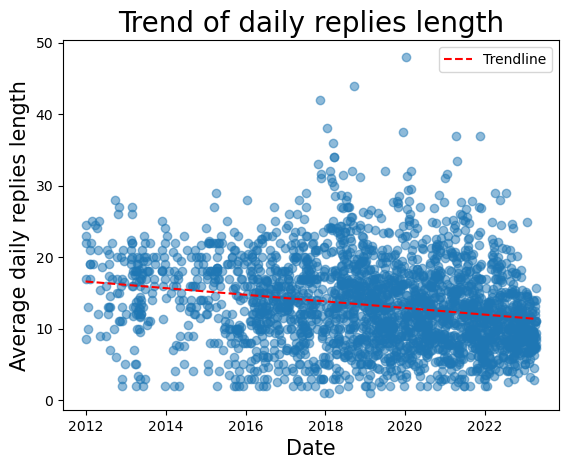

The negative slope trendline is more pronounced for tweets than for replies.


In [19]:
plot_trend(tweets[['text_length','day']].groupby(by = 'day').mean().reset_index(), title =  'Trend of daily tweets length', ylabel = 'Average daily tweets length')
plot_trend(replies[['text_length','day']].groupby(by = 'day').mean().reset_index(), title =  'Trend of daily replies length', ylabel = 'Average daily replies length')

print("The negative slope trendline is more pronounced for tweets than for replies.")
# ^ we can find the trendline equation, but its probably not that interesting.

### Tweet metric distribution analysis

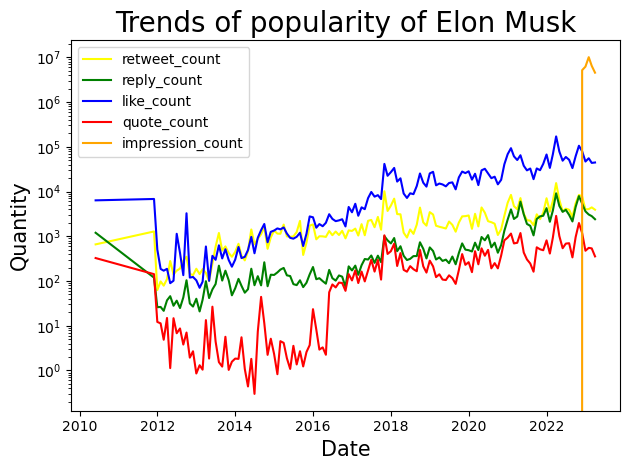

Note that impression count appeared recently, so all the data before Elon took over Twitter is missing.


In [20]:
def plot_metrics(df,title,log = False):
  colors = ['yellow','green','blue', 'red', 'orange']
  for i, col in enumerate(df.columns):
    if log: plt.yscale('log')
    plt.plot(df.index, df[col], color=colors[i], label=col)

  axes = plt.gca()
  axes.xaxis.label.set_size(15)
  axes.yaxis.label.set_size(15)
  plt.title('Trends of popularity of ' + title,fontsize = 20)
  plt.xlabel('Date')
  plt.ylabel('Quantity')
  plt.legend()
  plt.tight_layout()
  plt.show() 

# Extract metrics 
metrics = df[df['text'] != '']
metrics['day'] = metrics['day'].apply(lambda date: date.replace(day = 1,hour=0, minute=0, second=0, microsecond=0))
metrics = metrics[['day', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count']].groupby('day').mean()
plot_metrics(metrics, 'Elon Musk', log = True)

print("Note that impression count appeared recently, so all the data before Elon took over Twitter is missing.")

### What time does elon musk tweet?

[]

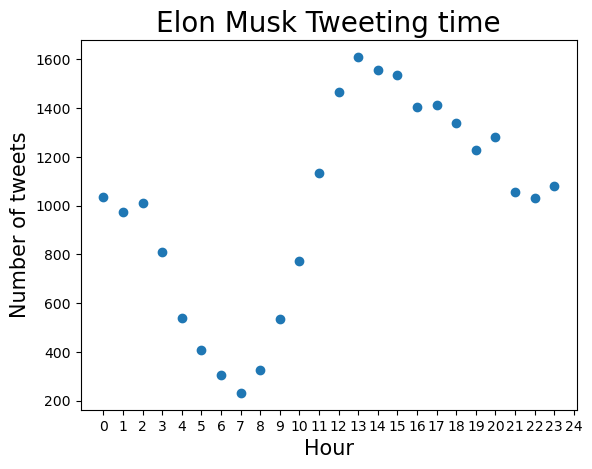

In [21]:
def time_mapper(hour):
  if hour < 5: return hour + 19
  else:        return hour - 5 
x = df['created_at'].apply(lambda time: time_mapper(int(str(time)[11:13]))).value_counts().index.values
y = df['created_at'].apply(lambda time: time_mapper(int(str(time)[11:13]))).value_counts().values
axes = plt.gca()
axes.xaxis.label.set_size(15)
axes.yaxis.label.set_size(15)
plt.xlabel('Hour')
plt.ylabel('Number of tweets')
plt.title("Elon Musk Tweeting time",fontsize = 20)
plt.xticks(range(0,25))
plt.scatter(x,y)

plt.plot()

### Next I'll look at the words that make up the tweets

We'll need to pre-process them by removing stopwords, verbs, tags and lemming, stemming and so on..

In [22]:
def clean(series, remove_at = False, lowercase = True):
    "function that cleans a quote"
    series = remove_verbs(series)
    series = series.apply(lambda x: remove_mentions_and_hashtags(x, remove_at))
    # series = remove_ats(series)
    # series = series.str.replace('(\@\w+.*?)',"")
    # series = remove_tags(series)

    series = hp.fillna(series)
    if lowercase:
        series = hp.lowercase(series)
    series = hp.remove_digits(series)
    series = hp.remove_diacritics(series)
    # default_stopwords = hero.stopwords.DEFAULT
    # custom_stopwords = default_stopwords.union(set(["@"]))
    series = hp.remove_stopwords(series)
    series = hp.remove_whitespace(series)
    series = hp.remove_punctuation(series)
    series = hp.fillna(series)
    
    return series

def remove_ats(series):
    def inner(X):
        X = X.split()
        print(X)
        X_new = [x for x in X if not x.startswith("@")]
        return ' '.join(X_new)
    return series.apply(inner)
    
def remove_tags(series):
    def inner(X):
        X = X.split()
        X_new = [x for x in X if not x.startswith("#")]
        return ' '.join(X_new)
    return series.apply(inner)

def remove_mentions_and_hashtags(text, replace_at = False):
    """
    Removes words starting with '@' or '#' from a given text string.
    """
    text = "".join(text).split()

    # Also remove english stop words
    stop_words = set(stopwords.words('english'))
    stop_words.add('rt')
    stop_words.add('amp')
    if not replace_at:
        text_without_mentions_and_hashtags = [word for word in text if (not word.startswith(('@','#')) and word not in stop_words)]
    else:
        text_without_mentions_and_hashtags = [word for word in text if (not word.startswith('#') and word not in stop_words)]
        text_without_mentions_and_hashtags = [word.replace('@','') for word in text_without_mentions_and_hashtags]

    # Stem the stext with Snowball stemmer
    stemmer = SnowballStemmer("english")
    text_without_mentions_and_hashtags = [stemmer.stem(word) for word in text_without_mentions_and_hashtags]
    return " ".join(text_without_mentions_and_hashtags)

def remove_verbs(series):
    """ function that removes all verbs from a series of sentences (series in the sense of pandas)"""
    def remove_verbs_from_sentence(sentence):
        """ function that removes all verbs from a sentence"""
        #tokenizes the sentence (makes it become a list of words)
        tokens = nltk.word_tokenize(sentence)

        #tags words, for example if the word is a verb in it's base form then it tags it with 'VB'
        #tagged becomes a list of tuples with (verb,tag) as format
        tagged = nltk.pos_tag(tokens)

        #filter all verbs from list
        tagged =list(filter(lambda x: x[1] not in  ['VB','VBD','VBG','VBN','VBP','VBZ','MD'],tagged))
 
        #remove tags from words
        words = list(map(lambda x: x[0], tagged))

        #join the words to have a sentence once againg
        sentence = ' '.join(words)
        return sentence

    return series.apply(remove_verbs_from_sentence)

In [23]:
# Need to install "punkt" and "averaged_perceptron_tagger" packages with the following line:
# nltk.download()

processed_text = clean(df['text'].apply(lambda text: " ".join([word for word in text.split() if not word.startswith(('@','#', 'https','http', 'co', 'rt', 'RT'))])))

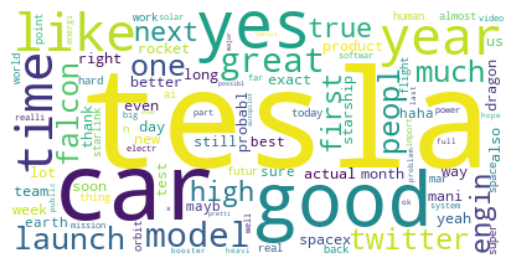

In [24]:
words = hero.top_words(processed_text)

word_count_dict = dict(zip(words.index, words.values))
# Create WordCloud object with word count dictionary
wordcloud = WordCloud(background_color='white', max_words=100).generate_from_frequencies(word_count_dict)

# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
words[:28]

text
tesla      1789
car         853
good        811
yes         751
year        727
like        726
time        700
great       678
model       674
launch      598
one         575
twitter     566
peopl       565
much        562
falcon      521
first       497
engin       489
true        485
high        479
next        465
product     461
spacex      449
day         440
new         418
rocket      411
yeah        410
exact       406
also        406
Name: count, dtype: int64

In [26]:
# Checking how many cahstags are there
mask = df['cashtags'].apply(lambda x: x.size > 0)
cashtags = df[mask]
cashtags.shape

(6, 14)

##### Looking to implement NER wordcloud and average sentiment over time

In [63]:
import sys
sys.path.append("../modules")

from nlp import BERTWrapperForNER

ner_model_wrapper = BERTWrapperForNER()

In [28]:
df['processed_text']= processed_text

In [29]:
t = ner_model_wrapper(processed_text.to_list())

In [30]:
pd.Series(t).value_counts()

[]              24051
[bbc]               6
[tesla]             5
[star]              2
[te]                1
[ye]                1
[g]                 1
[wifi]              1
[westworld]         1
[teslatari]         1
[hawthorn]          1
[dragon]            1
[lmk]               1
[av]                1
[space]             1
[m]                 1
[eberhard]          1
[eber]              1
[starlink]          1
[appl]              1
[w]                 1
[at]                1
[atlanta]           1
[spacex]            1
[virginiadm]        1
Name: count, dtype: int64

In [31]:
processed_text_with_replaced_ats = clean(df['text'].apply(lambda text: " ".join([word for word in text.split() if not word.startswith(('#', 'https','http', 'co', 'rt', 'RT'))])), remove_at = True, lowercase= False)
t2 = ner_model_wrapper(processed_text_with_replaced_ats.to_list())

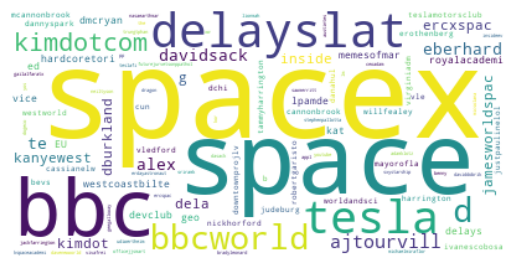

In [32]:
# keep only non-empty lists in t2
t3 = [x for x in t2 if x != []]

# flatten the list
t3 = [item for sublist in t3 for item in sublist]

# make it into dict of frequencies
t3 = pd.Series(t3).value_counts().to_dict()

wordcloud_2 = WordCloud(background_color='white', max_words=100).generate_from_frequencies(t3)

# Display the generated image
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
t3

{'spacex': 25,
 'space': 21,
 'bbc': 12,
 'delayslat': 7,
 'tesla': 7,
 'bbcworld': 6,
 'd': 6,
 'kimdotcom': 5,
 'ajtourvill': 4,
 'eberhard': 3,
 'davidsack': 3,
 'alex': 3,
 'te': 3,
 'ercxspac': 2,
 'jamesworldspac': 2,
 'g': 2,
 'dela': 2,
 'kanyewest': 2,
 'inside': 2,
 'dburkland': 2,
 'kimdot': 2,
 'ed': 1,
 'delays': 1,
 'westcoastbilte': 1,
 'memesofmar': 1,
 'lpamde': 1,
 'devclub': 1,
 'hardcoretori': 1,
 'EU': 1,
 'dmcryan': 1,
 'royalacademi': 1,
 'vice': 1,
 'kat': 1,
 'geo': 1,
 'teslamotorsclub': 1,
 'willfealey': 1,
 'worldandsci': 1,
 'mcannonbrook': 1,
 'virginiadm': 1,
 'tammyharrington': 1,
 'ivanescobosa': 1,
 'downtownprojlv': 1,
 'dannyspark': 1,
 'erothenberg': 1,
 'danahul': 1,
 'judeburg': 1,
 'cannonbrook': 1,
 'nickhorford': 1,
 'cun': 1,
 'dchi': 1,
 'westworld': 1,
 'vledford': 1,
 'b': 1,
 'vle': 1,
 'harrington': 1,
 'bevs': 1,
 'cassianelw': 1,
 'robertgaristo': 1,
 'mayorofla': 1,
 'justpaulinelol': 1,
 'jackfarrington': 1,
 'dragon': 1,
 'appl': 1,


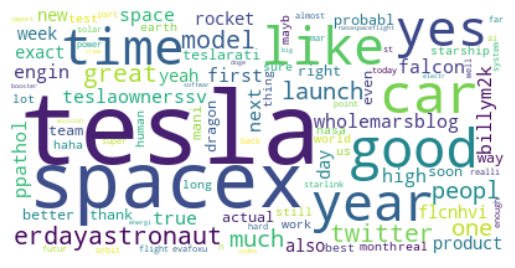

In [34]:
words_new = hero.top_words(processed_text_with_replaced_ats)

word_count_dict_new = dict(zip(words_new.index, words_new.values))
# Create WordCloud object with word count dictionary
wordcloud_new = WordCloud(background_color='white', max_words=100).generate_from_frequencies(word_count_dict_new)

# Display the generated image
plt.imshow(wordcloud_new, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
words_new[:28]

text
tesla             3076
spacex            1930
car                853
good               809
year               727
like               726
time               706
yes                695
erdayastronaut     692
twitter            684
great              678
model              673
launch             599
one                575
peopl              565
much               562
wholemarsblog      544
teslaownerssv      528
falcon             521
billym2k           502
first              497
engin              487
true               483
ppathol            482
space              480
high               480
next               465
product            461
Name: count, dtype: int64

#### Now let's look at Sentiment Analysis trends over time!

In [76]:
from nlp import BERTWrapperForSA
from nlp import VaderSentimentWrapper


In [37]:
# BERT
sa_model_wrapper = BERTWrapperForSA(BERTWrapperForSA.FIN_BERT_ID)

# This line crashes the kernel for some reason
# Update: it's because of the GPU memory limit. We need to do it in batches (who would have thought...)
# labels = sa_model_wrapper(processed_text.to_list())
# labeled_probabilities = sa_model_wrapper.predict(labels, labeled=True)

# provide sa_model_wrapper with batches of text taken from processed_text
# take care of the case where len(processed_text) % batch_size != 0, i.e. the last batch is smaller than batch_size
def get_sentiment_from_batches(processed_text, batch_size = 500, model = sa_model_wrapper):
    labels = []
    labeled_probabilities = []
    for i in range(0, len(processed_text), batch_size):
        labels += model(processed_text[i:i+batch_size].to_list())
        labeled_probabilities += model.predict(processed_text[i:i+batch_size].to_list(), labeled=True)
    return labels, labeled_probabilities



In [38]:
labels, labeled_probabilities = get_sentiment_from_batches(processed_text)

In [39]:
pd.Series(labels).value_counts()

neutral     23199
positive      579
negative      307
Name: count, dtype: int64

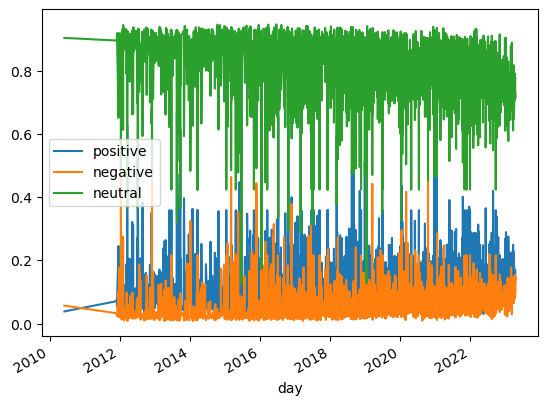

In [40]:
s = pd.DataFrame.from_dict(labeled_probabilities)
s['day'] = df['day']

# I have a dataframe of days and probabilities of being positive, negative or neutral
# I want to plot the evolution of these probabilities over time
# I will do this by grouping by day and taking the mean of the probabilities
def plot_sentiment_evolution(s):
    s = s.groupby('day').mean()
    s.plot()
    plt.show()
plot_sentiment_evolution(s)

In [41]:
df['finbert_sentiment'] = labels
s[['positive', 'negative', 'neutral']].value_counts()


positive  negative  neutral 
0.359163  0.216652  0.424185    2799
0.107706  0.035930  0.856364     420
0.099048  0.057302  0.843650     226
0.074126  0.029420  0.896454     196
0.133836  0.035092  0.831072     110
                                ... 
0.051059  0.067473  0.881468       1
0.051061  0.026767  0.922172       1
0.051062  0.034788  0.914150       1
0.051063  0.050602  0.898335       1
0.957913  0.018514  0.023573       1
Name: count, Length: 17673, dtype: int64

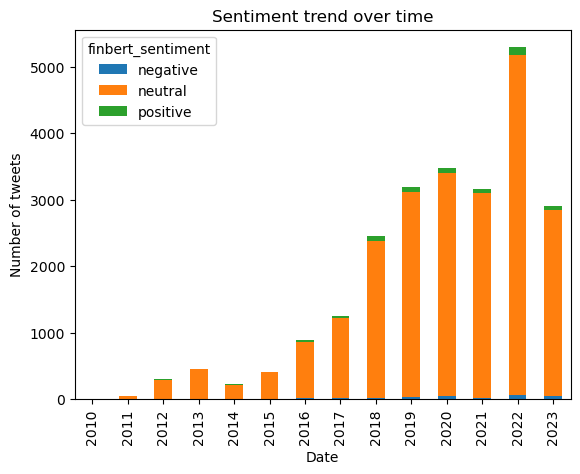

/var/folders/dk/kt0tgs8j1cb1k_hn1_h2bch80000gn/T/ipykernel_43486/2035261740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['day'].apply(lambda x: x.strftime('%Y'))


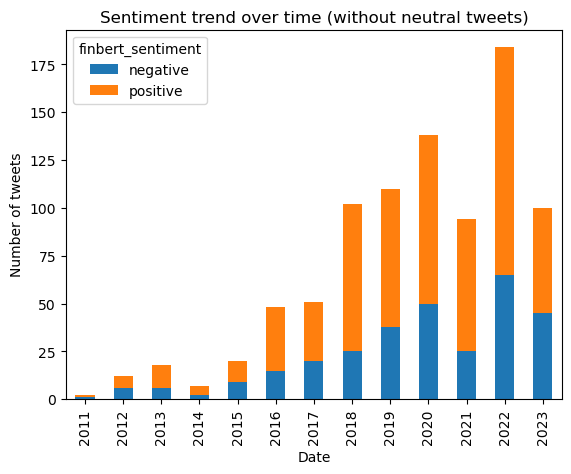

In [42]:
def plot_sentiment_evolution_finbert(df, title = 'Sentiment trend over time', sentiment = 'finbert_sentiment'):    
    # Group the data by date and sentiment, and count the number of rows in each group
    df['month'] = df['day'].apply(lambda x: x.strftime('%Y'))
    grouped = df.groupby(['month', sentiment]).size().reset_index(name='count')

    # Pivot the data to create a separate column for each sentiment
    pivot = grouped.pivot(index='month', columns=sentiment, values='count')

    # Plot the trend of sentiment over time
    pivot.plot(kind='bar', stacked=True)
    

    # Set the axis labels and title
    plt.xlabel('Date')
    plt.ylabel('Number of tweets')
    plt.title(title)

    # Show the plot
    plt.show()
plot_sentiment_evolution_finbert(df)
anti_neutral_mask = df['finbert_sentiment'] != 'neutral'
plot_sentiment_evolution_finbert(df[anti_neutral_mask], title = 'Sentiment trend over time (without neutral tweets)')

In [72]:
# TweetBert
sa_model_wrapper_tweetB = BERTWrapperForSA(BERTWrapperForSA.TWEET_BERT_ID)

tweetb_labels, tweetb_labeled_probabilities = get_sentiment_from_batches(processed_text, model=sa_model_wrapper_tweetB)

In [73]:
pd.Series(tweetb_labels).value_counts()

NEU    19107
POS     3610
NEG     1368
Name: count, dtype: int64

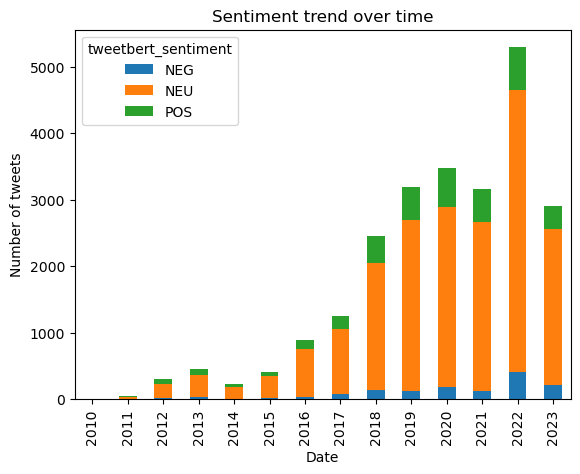

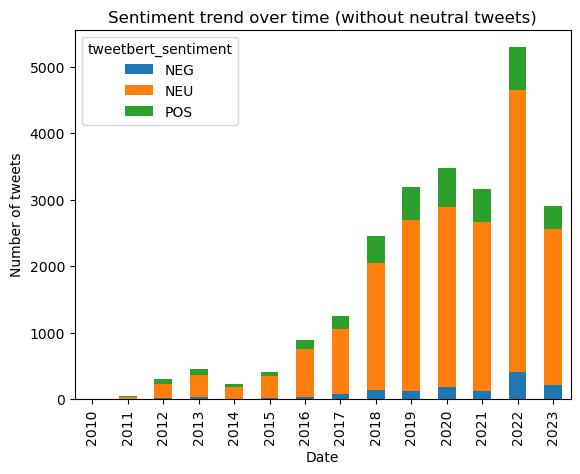

In [74]:
df['tweetbert_sentiment'] = tweetb_labels
plot_sentiment_evolution_finbert(df, sentiment='tweetbert_sentiment')
anti_neutral_mask = df['tweetbert_sentiment'] != 'neutral'
plot_sentiment_evolution_finbert(df[anti_neutral_mask], title = 'Sentiment trend over time (without neutral tweets)', sentiment='tweetbert_sentiment')

In [77]:
# DistilBert
# Note that distil bert only has positive/negative ratings, no neutral. keep that in mind
sa_model_wrapper_distil = BERTWrapperForSA(BERTWrapperForSA.DISTILBERT_ID)

distil_labels, distil_labeled_probabilities = get_sentiment_from_batches(processed_text, model=sa_model_wrapper_distil)

In [83]:
print("LABEL_1 == Positive\nLABEL_0 == Negative")
pd.Series(distil_labels).value_counts()

LABEL_1 == Positive
LABEL_0 == Negative


LABEL_1    14286
LABEL_0     9799
Name: count, dtype: int64

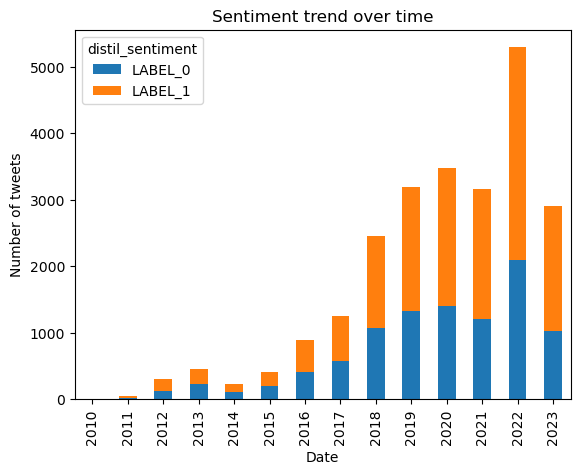

In [79]:
df['distil_sentiment'] = distil_labels
plot_sentiment_evolution_finbert(df, sentiment='distil_sentiment')
# anti_neutral_mask = df['distil_sentiment'] != 'neutral'
# plot_sentiment_evolution_finbert(df[anti_neutral_mask], title = 'Sentiment trend over time (without neutral tweets)', sentiment='distil_sentiment')

In [46]:
# Vader
vader_model_wrapper = VaderSentimentWrapper()
vader_scores = vader_model_wrapper.compute_scores(processed_text.to_list())
vader_scores

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.233, 'pos': 0.767},
 {'neg': 0.0, 'neu': 0.309, 'pos': 0.691},
 {'neg': 0.0, 'neu': 0.881, 'pos': 0.119},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'neg': 0.286, 'neu': 0.714, 'pos': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 0.0},
 {'neg': 0.531, 'neu': 0.469, 'pos': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'ne

In [47]:
df['vader_sentiment'] = pd.Series(vader_scores).map(lambda x: 'NEG' if x['neg'] > max(x['pos'], x['neu']) else ('POS' if x['pos'] > max(x['neg'], x['neu']) else 'NEU'))
df['vader_sentiment'].value_counts()

vader_sentiment
NEU    19424
POS     4002
NEG      659
Name: count, dtype: int64

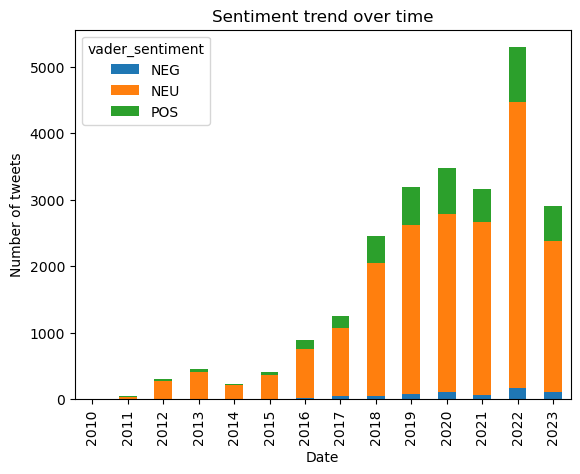

In [48]:
def plot_sentiment_evolution_vader(df, title = 'Sentiment trend over time'):    
    # Group the data by date and sentiment, and count the number of rows in each group
    df['month'] = df['day'].apply(lambda x: x.strftime('%Y'))
    grouped = df.groupby(['month', 'vader_sentiment']).size().reset_index(name='count')

    # Pivot the data to create a separate column for each sentiment
    pivot = grouped.pivot(index='month', columns='vader_sentiment', values='count')

    # Plot the trend of sentiment over time
    pivot.plot(kind='bar', stacked=True)
    

    # Set the axis labels and title
    plt.xlabel('Date')
    plt.ylabel('Number of tweets')
    plt.title(title)

    # Show the plot
    plt.show()


plot_sentiment_evolution_vader(df)

/var/folders/dk/kt0tgs8j1cb1k_hn1_h2bch80000gn/T/ipykernel_43486/1492030194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['day'].apply(lambda x: x.strftime('%Y'))


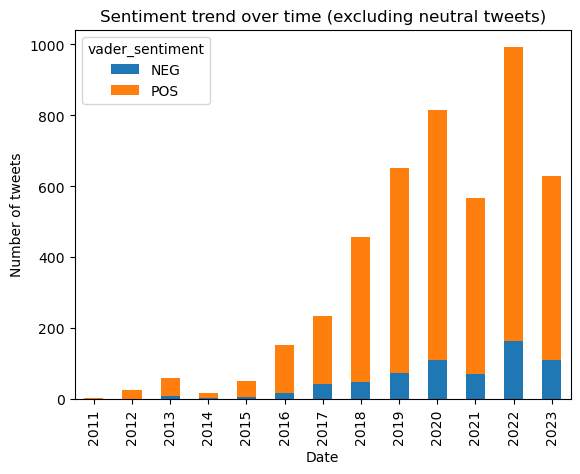

We observe a big imbalance of negative vs positive tweets. This might cause biases in the model.


In [49]:
anti_neutral_mask = df['vader_sentiment'] != 'NEU'
plot_sentiment_evolution_vader(df[anti_neutral_mask], title = 'Sentiment trend over time (excluding neutral tweets)')
print("We observe a big imbalance of negative vs positive tweets. This might cause biases in the model.")

In [88]:
# Looking for top tweets for farouk
# df.sort_values(by='like_count', ascending=False).head(15)[['id', 'day', 'text', 'tweetbert_sentiment']].to_csv('../data/farouk_tweets.csv', index=False)

In [5]:
TESLA_KEYWORDS = {'tsla', 'tesla', 'motors', 'tes- lamotors', 'tslamotors', 'car', 'truck', 'electric','model', 'models', 'modelx', 'chassis', 'cars', 'battery', 'batteries', 'vehicle', 'model3', 'miles', 'autonomy', 'supercharger', 'charger', 'ev', 'evs', 'gigafactory', 'diesel', 'gasoil', 'renewable'}

def get_tesla_tweets(df):
    return df[df['text'].map(lambda x: len(TESLA_KEYWORDS.intersection(set(x.lower().split(' ')))) > 0)]

tesla_tweets = get_tesla_tweets(df)
tesla_tweets.sort_values(by='like_count', ascending=False).head(15)#[['id', 'day', 'text', 'tweetbert_sentiment']]#.to_csv('../data/farouk_tesla_tweets.csv', index=False)

,id,created_at,text,hashtags,mentions,cashtags,is_reply,retweet_count,reply_count,like_count,quote_count,impression_count,text_length,day
10750,1374617643446063105,2021-03-24T07:02:40.000Z,You can now buy a Tesla with Bitcoin,[],[],[],False,102544,33568,828057,23779,0,8,2021-03-24
11170,1354890601649610753,2021-01-28T20:34:26.000Z,u can’t sell houses u don’t own\nu can’t sell ...,[],[],[],False,125117,20190,682368,13762,0,35,2021-01-28
11193,1354618504532684802,2021-01-28T02:33:13.000Z,Plaid Model S ships next month https://t.co/HF...,[],[],[],False,30953,13418,441232,7401,0,7,2021-01-28
10322,1395027147161489412,2021-05-19T14:42:44.000Z,Tesla has 💎 🙌,[],[],[],False,52304,66547,433511,19603,0,4,2021-05-19
13565,1259945593805221891,2020-05-11T20:36:52.000Z,Tesla is restarting production today against A...,[],[],[],False,56808,28207,428990,26404,0,29,2020-05-11
3778,1599269250375380992,2022-12-04T05:07:56.000Z,@POTUS Or you can just buy a Tesla,[],[POTUS],[],True,17471,12753,414505,1397,0,8,2022-12-04
20401,960992715579125760,2018-02-06T21:44:52.000Z,"View from SpaceX Launch Control. Apparently, t...",[],[],[],False,141600,11579,411871,19246,0,15,2018-02-06
1875,1626703667591270400,2023-02-17T22:02:31.000Z,This is my finest work – please add to gravest...,[],[],[],False,22554,12859,381145,2707,62383877,16,2023-02-17
7229,1518234561150427141,2022-04-24T14:25:01.000Z,(from making fun of Gates for shorting Tesla w...,[],[],[],True,20146,11669,380410,1928,0,15,2022-04-24
11085,1358176884312272898,2021-02-06T22:12:57.000Z,Time to tell the story of Tesla &amp; SpaceX,[],[],[],False,21171,10922,377738,2035,0,9,2021-02-06


In [4]:
TWITTER_KEYWORDS = {'twitter', 'tweet', 'tweets', 'social media', 'follow', 'follower', 'retweet', 'like', 'hashtag', 'trending', 'DM', 'direct message', 'notification', 'profile', 'verified', 'blue tick', 'mention', 'mentioning', 'timeline', 'explore', 'comment', 'reply', 'thread', 'hashtagging', 'feed', 'newsfeed', 'media', 'microblogging', 'twt', 'content', 'creator', 'creators', 'content creator', 'content creators', 'platform', 'subscription', 'checkmark', 'blue', 'blue checkmark', 'subscribe'}

def get_twitter_tweets(df):
    return df[df['text'].map(lambda x: len(TWITTER_KEYWORDS.intersection(set(x.lower().split(' ')))) > 0)]

twitter_tweets = get_twitter_tweets(df)
twitter_tweets.sort_values(by='like_count', ascending=False).head(15)#[['id', 'day', 'text', 'tweetbert_sentiment']]#.to_csv('../data/farouk_twitter_tweets.csv', index=False)

,id,created_at,text,hashtags,mentions,cashtags,is_reply,retweet_count,reply_count,like_count,quote_count,impression_count,text_length,day
7180,1519495072802390016,2022-04-28T01:53:50.000Z,Let’s make Twitter maximum fun!,[],[],[],False,188474,112010,2584765,36706,0,5,2022-04-28
4904,1586104694421659648,2022-10-28T21:16:42.000Z,Comedy is now legal on Twitter,[],[],[],False,244124,89577,2321947,40971,0,6,2022-10-28
7189,1519415674111672325,2022-04-27T20:38:20.000Z,"For Twitter to deserve public trust, it must b...",[],[],[],False,140510,78198,1514319,29900,0,23,2022-04-27
7184,1519469891455234048,2022-04-28T00:13:47.000Z,Twitter DMs should have end to end encryption ...,[],[],[],False,104482,41265,1427853,17757,0,20,2022-04-28
4266,1594191387519373313,2022-11-20T04:50:20.000Z,Twitter is ALIVE,[],[],[],False,109710,88302,1408373,22344,0,3,2022-11-20
4925,1585341984679469056,2022-10-26T18:45:58.000Z,Entering Twitter HQ – let that sink in! https:...,[],[],[],False,177517,66787,1359018,43655,0,9,2022-10-26
4600,1590755506112823296,2022-11-10T17:17:22.000Z,I love when people complain about Twitter … on...,[],[],[],False,104995,79885,1295157,29216,0,11,2022-11-10
1958,1625695877326340102,2023-02-15T03:17:55.000Z,The new CEO of Twitter is amazing https://t.co...,[],[],[],False,91577,43662,1268982,14187,139273147,8,2023-02-15
7130,1520650036865949696,2022-05-01T06:23:15.000Z,Since I’ve been asked a lot:\n\nBuy stock in s...,[],[],[],False,106385,42547,1073979,9478,0,46,2022-05-01
4177,1595207476936413187,2022-11-23T00:07:54.000Z,Wasn’t Twitter supposed to die by now or somet...,[],[],[],False,67085,67063,955166,12938,0,11,2022-11-23
